## Exercise 1
Tasks:
- Cluster the types of crimes based on the success of the police in facing/solving them.
- Cluster the types of crimes and explain what each cluster represents.
- Identify outliers in crime types and explain what they represent/why they are outliers.
- Try to predict the super-category (e.g. ΕΠΙΚΡΑΤΕΙΑ/ΚΛΟΠΕΣ-ΔΙΑΡΡΗΞΕΙΣ, ...) of a record given
only its numeric fields (τελ/να, απόπειρες, εξιχνιάσεις, ημεδαποί, αλλοδαποί), providing an explanation
of the main factors for the decision and report the performance on a cross-validation evaluation.

In [1]:
from collections import OrderedDict
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
import seaborn as sns
from sklearn import metrics, svm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier

sns.set(style = "darkgrid")

The data in the excel contained supercategories such as "ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ" etc, so it was slightly transformed.

These columns were removed from the initial data and "ΕΠΙΚΡΑΤΕΙΑ" was replaced by "ΟΝΟΜΑ ΕΓΚΛΗΜΑΤΟΣ".

The supercategories were then moved in a new tab named "ΥΠΕΡΚΛΑΣΕΙΣ".

In [2]:
FILE_NAME = "2016_epikrateia.xlsx"

# load the first two sheets
dfs = pd.read_excel(FILE_NAME, sheet_name=[0, 1])
data_df = dfs[0]  # type: pd.DataFrame
superclass_df = dfs[1]  # type: pd.DataFrame

data_df.head()

,ΟΝΟΜΑ ΕΓΚΛΗΜΑΤΟΣ,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί
0,ΑΝΘΡΩΠΟΚΤΟΝΙΕΣ,81,132,183,169,95
1,ΑΠΑΤΕΣ,3790,1189,2066,994,247
2,ΑΡΧΑΙΟΚΑΠΗΛΕΙΑ,155,19,174,161,22
3,ΒΙΑΣΜΟΙ,155,82,164,102,91
4,ΕΚΒΙΑΣΕΙΣ,135,23,89,100,55


In [3]:
data_df.tail()

,ΟΝΟΜΑ ΕΓΚΛΗΜΑΤΟΣ,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί
37,Ληστείες σε πρακτορεία ΟΠΑΠ,31,5,3,3,5
38,Ληστείες σούπερ μάρκετ,127,2,50,24,10
39,Ληστείες ταχυδρομικών διανομέων,4,3,1,2,0
40,"Ληστείες τραπεζών,ταχ/κών ταμιευτηρίων",14,2,12,8,0
41,Ληστείες χρηματαποστολών,21,2,1,3,0


In [4]:
superclass_df.head()

,ΟΝΟΜΑ,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί
0,ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ,34805,1483,25964,21089,9573
1,ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ,75083,5469,14798,9990,3961
2,ΚΛΟΠΕΣ ΤΡΟΧΟΦΟΡΩΝ,26180,720,8543,1405,451
3,ΛΗΣΤΕΙΕΣ,4738,325,1582,1295,618


For the first task we have to cluster the types of crimes based on the success of the police in facing/solving them.

In order to achieve this, we have to keep the columns "τελ/να" and "απόπειρες".
The type of clustering that was chosen is Hierarchical clustering since we have few data, and we do not know the number
of clusters beforehand.

However, the decision of the number of clusters that can best depict different groups can be
chosen by observing the dendrogram.
The best choice of the number of clusters is the no. of vertical lines in the dendrogram cut by a
horizontal line that can transverse the maximum distance vertically without intersecting a
cluster.

For k- means clustering we would need to have prior knowledge about the clusters.

In [5]:
task_1_df = data_df[["τελ/να", "εξιχνιάσεις"]]

We have to normalize the data so that the scale of each variable is the same. Why is this important?

If the scale of the variables is not the same, the model might become biased towards
the variables with a higher magnitude like ΑΠΑΤΕΣ or ΕΠΑΙΤΕΙΑ.

In [6]:
data_scaled = normalize(task_1_df)
data_scaled = pd.DataFrame(data_scaled, columns=task_1_df.columns)
data_scaled.head()

,τελ/να,εξιχνιάσεις
0,0.404747,0.914429
1,0.878019,0.478625
2,0.665163,0.746699
3,0.686884,0.726767
4,0.834894,0.550411


The x-axis contains the samples and y-axis represents the distance between these samples.
The vertical line with maximum distance is the blue line and hence we can decide a threshold of 1 and cut the dendrogram


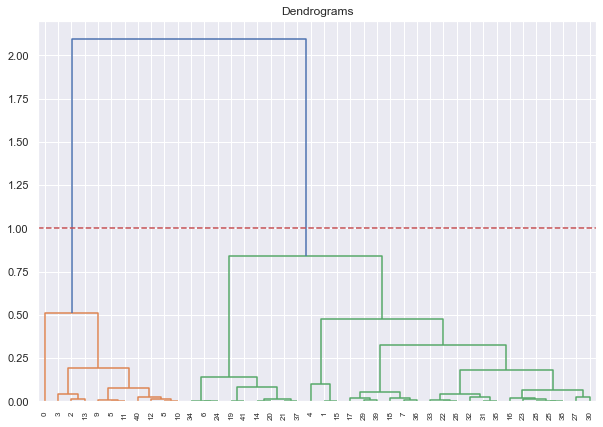

In [7]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dendrogram = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1, color='r', linestyle='--')

We have two clusters as this line cuts the dendrogram at two points.
Let’s now apply hierarchical clustering for 2 clusters


In [8]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_scaled)

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      dtype=int64)

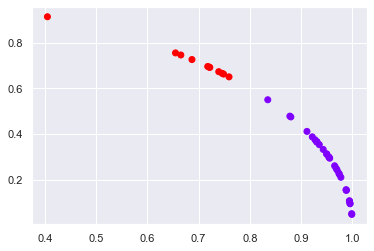

In [9]:
plt.scatter(data_scaled["τελ/να"], data_scaled["εξιχνιάσεις"], c=cluster.labels_, cmap='rainbow')

In [10]:
# Map crime names to their cluster.
crimes_names = data_df["ΟΝΟΜΑ ΕΓΚΛΗΜΑΤΟΣ"].tolist()
clusters = OrderedDict(zip(crimes_names, cluster.labels_))
pprint(clusters)

OrderedDict([('ΑΝΘΡΩΠΟΚΤΟΝΙΕΣ', 1),
             ('ΑΠΑΤΕΣ', 0),
             ('ΑΡΧΑΙΟΚΑΠΗΛΕΙΑ', 1),
             ('ΒΙΑΣΜΟΙ', 1),
             ('ΕΚΒΙΑΣΕΙΣ', 0),
             ('ΕΠΑΙΤΕΙΑ', 1),
             ('ΖΩΟΚΛΟΠΗ', 0),
             ('ΚΥΚΛΟΦΟΡΙΑ ΠΑΡΑΧΑΡΑΓΜΕΝΩΝ', 0),
             ('ΛΑΘΡΕΜΠΟΡΙΟ', 1),
             ('Ν περί ΝΑΡΚΩΤΙΚΩΝ', 1),
             ('Ν περί ΟΠΛΩΝ', 1),
             ('Ν περί ΠΝΕΥΜΑΤΙΚΗΣ ΙΔΙΟΚΤΗΣΙΑΣ', 1),
             ('ΠΛΑΣΤΟΓΡΑΦΙΑ', 1),
             ('ΣΕΞΟΥΑΛΙΚΗ ΕΚΜΕΤΑΛΛΕΥΣΗ', 1),
             ('Κλοπές - Διαρρήξεις από ιχε αυτ/τα', 0),
             ('Κλοπές - Διαρρήξεις ιερών ναών', 0),
             ('Κλοπές - Διαρρήξεις καταστημάτων', 0),
             ('Κλοπές - Διαρρήξεις λοιπές', 0),
             ('Κλοπές - Διαρρήξεις οικιών', 0),
             ('Κλοπές - Διαρρήξεις σε συγκοινωνιακά μέσα', 0),
             ('Κλοπές με αρπαγές τσαντών', 0),
             ('Κλοπές σε δημόσιο χώρο-μικροκλοπες', 0),
             ('Κλοπές Τροχοφόρων ΙΧΕ αυτ/των', 0),
             ('Κλοπές

For the second task we have to cluster the types of crimes and explain what each cluster represents. We will use the
same algorithm as before but this time we will keep all the columns except for the "ΟΝΟΜΑ ΕΓΚΛΗΜΑΤΟΣ"

In [11]:
task_2_df = data_df[["τελ/να", "απόπειρες", "εξιχνιάσεις", "ημεδαποί", "αλλοδαποί"]]
task_2_df.head()

,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί
0,81,132,183,169,95
1,3790,1189,2066,994,247
2,155,19,174,161,22
3,155,82,164,102,91
4,135,23,89,100,55


In [12]:
# normalize the data
data_scaled = normalize(task_2_df)
data_scaled = pd.DataFrame(data_scaled, columns=task_2_df.columns)
data_scaled.head()

,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί
0,0.262716,0.428129,0.593543,0.548135,0.308123
1,0.825177,0.258875,0.449819,0.216418,0.053778
2,0.544389,0.066732,0.611121,0.565463,0.077268
3,0.561027,0.296802,0.593603,0.369192,0.329377
4,0.677546,0.115434,0.446678,0.501886,0.276037


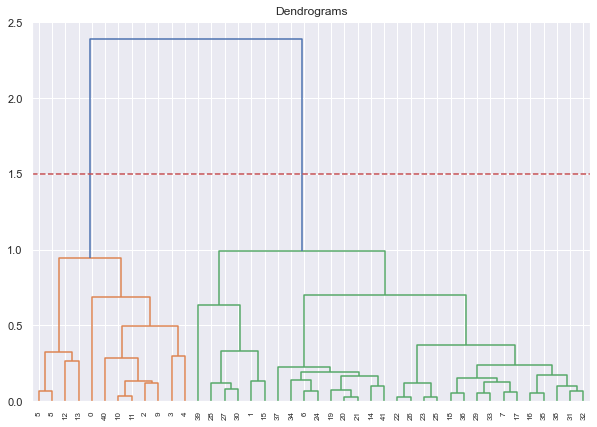

In [13]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dendrogram_2 = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1.5, color='r', linestyle='--')

The x-axis contains the samples and y-axis represents the distance between these samples.
The vertical line with maximum distance is the blue line and hence we can decide a threshold of 1.5 and
cut the dendrogram.

We have two clusters as this line cuts the dendrogram at two points.
Let’s now apply hierarchical clustering for 2 clusters

In [14]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_scaled)


array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      dtype=int64)

In [15]:
# Map crime names to their cluster.
crimes_names = data_df["ΟΝΟΜΑ ΕΓΚΛΗΜΑΤΟΣ"].tolist()
clusters = OrderedDict(zip(crimes_names, cluster.labels_))
pprint(clusters)

OrderedDict([('ΑΝΘΡΩΠΟΚΤΟΝΙΕΣ', 1),
             ('ΑΠΑΤΕΣ', 0),
             ('ΑΡΧΑΙΟΚΑΠΗΛΕΙΑ', 1),
             ('ΒΙΑΣΜΟΙ', 1),
             ('ΕΚΒΙΑΣΕΙΣ', 1),
             ('ΕΠΑΙΤΕΙΑ', 1),
             ('ΖΩΟΚΛΟΠΗ', 0),
             ('ΚΥΚΛΟΦΟΡΙΑ ΠΑΡΑΧΑΡΑΓΜΕΝΩΝ', 0),
             ('ΛΑΘΡΕΜΠΟΡΙΟ', 1),
             ('Ν περί ΝΑΡΚΩΤΙΚΩΝ', 1),
             ('Ν περί ΟΠΛΩΝ', 1),
             ('Ν περί ΠΝΕΥΜΑΤΙΚΗΣ ΙΔΙΟΚΤΗΣΙΑΣ', 1),
             ('ΠΛΑΣΤΟΓΡΑΦΙΑ', 1),
             ('ΣΕΞΟΥΑΛΙΚΗ ΕΚΜΕΤΑΛΛΕΥΣΗ', 1),
             ('Κλοπές - Διαρρήξεις από ιχε αυτ/τα', 0),
             ('Κλοπές - Διαρρήξεις ιερών ναών', 0),
             ('Κλοπές - Διαρρήξεις καταστημάτων', 0),
             ('Κλοπές - Διαρρήξεις λοιπές', 0),
             ('Κλοπές - Διαρρήξεις οικιών', 0),
             ('Κλοπές - Διαρρήξεις σε συγκοινωνιακά μέσα', 0),
             ('Κλοπές με αρπαγές τσαντών', 0),
             ('Κλοπές σε δημόσιο χώρο-μικροκλοπες', 0),
             ('Κλοπές Τροχοφόρων ΙΧΕ αυτ/των', 0),
             ('Κλοπές

We can see that the crimes are divided into 2 clusters. In the one cluster we have all crimes that belong to 'Ληστείες'
and 'Κλοπές` as well as some other general crimes while on the other cluster we have the rest of the crimes, with some
exceptions.

In [16]:
#Add the cluster vector to the DataFrame
new_data_scaled = data_scaled.copy()
new_data_scaled["Cluster"] = list(clusters.values())
new_data_scaled.head()

,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί,Cluster
0,0.262716,0.428129,0.593543,0.548135,0.308123,1
1,0.825177,0.258875,0.449819,0.216418,0.053778,0
2,0.544389,0.066732,0.611121,0.565463,0.077268,1
3,0.561027,0.296802,0.593603,0.369192,0.329377,1
4,0.677546,0.115434,0.446678,0.501886,0.276037,1


Now, to visualize our data, we will use a DataFrame by using the 'PCA' algorithm.
The DataFrame will hold the results of the PCA algorithm that returns three principal components.
This DataFrame will allow us to visualize the clusters in three-dimensional space (3-D).


In [17]:
#PCA with three principal components
pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(new_data_scaled.drop(["Cluster"], axis=1)))
# Note that, above, we performed our PCA's on data that excluded the Cluster variable.
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
# We concatenate the DataFrames so that they can be used by new_data_scaled as columns.
new_data_scaled = pd.concat([new_data_scaled, PCs_3d], axis=1, join='inner')
new_data_scaled.head()

,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί,Cluster,PC1_3d,PC2_3d,PC3_3d
0,0.262716,0.428129,0.593543,0.548135,0.308123,1,0.715759,0.194159,0.264171
1,0.825177,0.258875,0.449819,0.216418,0.053778,0,0.044746,0.124028,0.056750
2,0.544389,0.066732,0.611121,0.565463,0.077268,1,0.454188,0.143900,-0.170143
3,0.561027,0.296802,0.593603,0.369192,0.329377,1,0.447419,0.016783,0.170545
4,0.677546,0.115434,0.446678,0.501886,0.276037,1,0.324735,0.024627,0.014678


In [18]:
# we have two clusters
cluster_0 = new_data_scaled[new_data_scaled["Cluster"] == 0]
cluster_1 = new_data_scaled[new_data_scaled["Cluster"] == 1]
cluster_0.head()

,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί,Cluster,PC1_3d,PC2_3d,PC3_3d
1,0.825177,0.258875,0.449819,0.216418,0.053778,0,0.044746,0.124028,0.056750
6,0.977642,0.011860,0.152492,0.138937,0.038970,0,-0.276860,-0.008637,-0.015578
7,0.952386,0.000269,0.223426,0.206467,0.020324,0,-0.197837,0.019822,-0.074446
14,0.987829,0.090794,0.106819,0.062630,0.024864,0,-0.340997,0.016688,0.070356
15,0.808811,0.199272,0.436640,0.331143,0.076192,0,0.103184,0.128670,0.002182


In [19]:
cluster_1.head()

,τελ/να,απόπειρες,εξιχνιάσεις,ημεδαποί,αλλοδαποί,Cluster,PC1_3d,PC2_3d,PC3_3d
0,0.262716,0.428129,0.593543,0.548135,0.308123,1,0.715759,0.194159,0.264171
2,0.544389,0.066732,0.611121,0.565463,0.077268,1,0.454188,0.143900,-0.170143
3,0.561027,0.296802,0.593603,0.369192,0.329377,1,0.447419,0.016783,0.170545
4,0.677546,0.115434,0.446678,0.501886,0.276037,1,0.324735,0.024627,0.014678
5,0.638091,0.000000,0.611871,0.283505,0.371588,1,0.354007,-0.223049,-0.016435


### PCA Visualizations

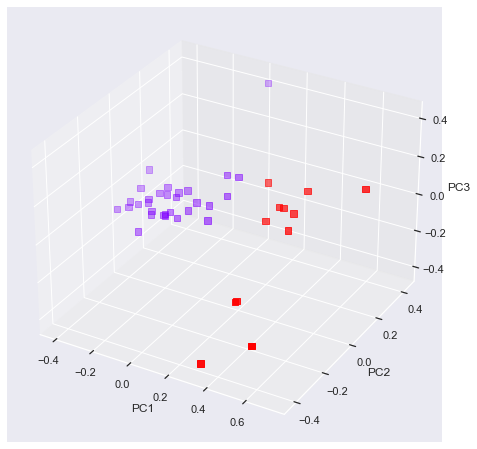

In [20]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection = '3d')

x = PCs_3d['PC1_3d']
y = PCs_3d['PC2_3d']
z = PCs_3d['PC2_3d']

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(x, y, z, marker="s", c=new_data_scaled["Cluster"], s=40, cmap="rainbow")

From the schema above we can see that the purple cluster is more dense and has few outliers, while the red cluster is
sparser with more outliers. We are going to use DBScan in order to identify the outliers.
In order to find a suitable value for DBScan epsilon value we can calculate the distance to the nearest n points for
each point, sorting and plotting the results. Then we look to see where the change is most pronounced and select that as epsilon.

In [21]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(new_data_scaled)
distances, indices = nbrs.kneighbors(new_data_scaled)
distances

array([[0.        , 0.50094289],
       [0.        , 0.15515318],
       [0.        , 0.14586858],
       [0.        , 0.35765661],
       [0.        , 0.32413679],
       [0.        , 0.07044338],
       [0.        , 0.08071731],
       [0.        , 0.08115556],
       [0.        , 0.07044338],
       [0.        , 0.12816274],
       [0.        , 0.0402368 ],
       [0.        , 0.0402368 ],
       [0.        , 0.34106234],
       [0.        , 0.34031556],
       [0.        , 0.10371976],
       [0.        , 0.15515318],
       [0.        , 0.06911811],
       [0.        , 0.08115556],
       [0.        , 0.07721408],
       [0.        , 0.08560942],
       [0.        , 0.03361623],
       [0.        , 0.03361623],
       [0.        , 0.03158667],
       [0.        , 0.03423989],
       [0.        , 0.07384212],
       [0.        , 0.03423989],
       [0.        , 0.03158667],
       [0.        , 0.11337601],
       [0.        , 0.14677307],
       [0.        , 0.06008847],
       [0.

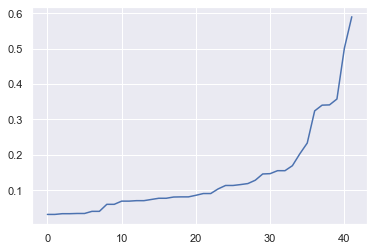

In [22]:
# Sort the distances and plot the results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The optimal value for epsilon will be found at the point of maximum curvature.
From the diagram above that point is 0.35
So DBScan will be used, selecting 0.35 for eps and setting min_samples to 5.

Estimated number of clusters: 1
Estimated number of noise points: 2
Silhouette Coefficient: 0.422


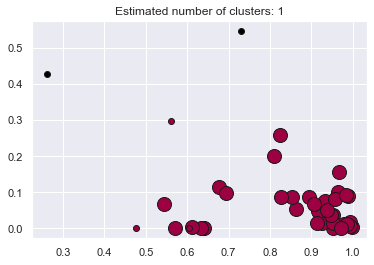

In [23]:
db = DBSCAN(eps=0.35, min_samples=5).fit(data_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data_scaled, labels))

unique_labels = set(labels)
colors = [plt.get_cmap('Spectral')(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

We can see that DBScan detects only one possible cluster with a minimum of 5 samples. By observing the cluster, we can
also see that it is a bit dense, however some samples are farther than others. Finally, we can only spot 2 outliers in the grid.


In [24]:
# Map the outliers to their labels.
clusters = OrderedDict(zip(crimes_names, labels))
outliers = [k for k in clusters.keys() if clusters[k] == -1]
outliers

['ΑΝΘΡΩΠΟΚΤΟΝΙΕΣ', 'Ληστείες ταχυδρομικών διανομέων']

The above data points are outliers. One possible explanation for this could be that the police keeps data from previous
years as well. For example, a crime could have been committed on a previous year, for example 2014, and it may have been
solved on 2016. Therefore, it will be included in the data.

For the predicting of the super category of the crimes we will use 4 algorithms: RandomForest, Decision Tree, SVM and KNN,
with GridSearch and cross validation, in order to find the best hyperparameters. These algorithms were chosen because they
are suitable for classification, especially the ensemble algorithm - RandomForest.

## Functions used for classification and reporting their results

In [25]:
def accuracy_per_class(target_test, pred):
    matrix = metrics.confusion_matrix(target_test, pred)
    acc_per_class = matrix.diagonal()/matrix.sum(axis=1)
    acc_per_class_dict = {i:v for i, v in enumerate(acc_per_class)}
    return acc_per_class_dict

def general_classification_report(target_test, pred):
    """
    General Classification Report
    :param target_test: target test data
    :param pred: the prediction of the classifier
    """
    print ("Classification Report")
    print(metrics.classification_report(target_test, pred))
    print("Accuracy per class")
    pprint(accuracy_per_class(target_test, pred))
    cmrforest = metrics.confusion_matrix(target_test , pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cmrforest ,annot=True , fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Report')


def perform_classification_with_grid_search(clf_name, data_train, data_test, target_train, target_test, cv=10):
    """
    Function that uses several classifiers with parameter tuning
    :param clf_name: Classifier name, can be Random Forest, SVM, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    :param cv: number of folds
    :return: A dictionary with the best parameters
    """
    if clf_name =='Random Forest':
        param_grid = {
            'n_estimators': [100],
            'max_features': ['auto'],
            'max_depth' : range(1, 10),
            'criterion' :['gini', 'entropy']
        }
        clf = RandomForestClassifier(random_state=42)

    elif clf_name =='SVM':
        param_grid =  {
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
        }
        clf = svm.SVC()

    elif clf_name =='kNN':
        param_grid = {'n_neighbors': range(1, 10)}
        clf = KNeighborsClassifier()

    elif clf_name =='Decision Tree':
        param_grid = {"criterion": ['gini', 'entropy'],
                      "max_depth": range(1, 10),
                      "min_samples_split": range(2, 10),
                      "min_samples_leaf": range(1, 5)
                      }
        clf = DecisionTreeClassifier()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    cv_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, verbose=0)
    cv_clf.fit(data_train, target_train.values.ravel())
     # Viewing The Best Parameters
    print('Best Parameters: ', cv_clf.best_params_)
    print('Best Accuracy Score Achieved in Grid Search: ', cv_clf.best_score_)
    best_estimator = cv_clf.best_estimator_
    # Predicting using the best estimator
    best_estimator.fit(data_train, target_train.values.ravel())
    pred=best_estimator.predict(data_test)
    general_classification_report(target_test, pred)
    best_estimator.score(data_test, target_test)

In [26]:
# Create the super-category DataFrame

data = []
for i in range(14):
    data.append("ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ")
for i in range(8):
    data.append("ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ")
for i in range(5):
    data.append("ΚΛΟΠΕΣ ΤΡΟΧΟΦΟΡΩΝ")
for i in range(15):
    data.append("ΛΗΣΤΕΙΕΣ")


df_y = pd.DataFrame(columns=['Supercategory'], data=data)
df_y.head()

,Supercategory
0,ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ
1,ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ
2,ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ
3,ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ
4,ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ


In [27]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(data_scaled, df_y, test_size=0.3, random_state=42)
print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (29, 5)
Test data shape:  (13, 5)


### Perform Classification using Random Forest Classifier

d:\pycharmprojects\data_mining_master_2020\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
Best Accuracy Score Achieved in Grid Search:  0.7333333333333333
Classification Report
                     precision    recall  f1-score   support

ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ       1.00      0.50      0.67         2
  ΚΛΟΠΕΣ ΤΡΟΧΟΦΟΡΩΝ       1.00      0.50      0.67         2
           ΛΗΣΤΕΙΕΣ       0.57      1.00      0.73         4
    ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ       1.00      0.80      0.89         5

           accuracy                           0.77        13
          macro avg       0.89      0.70      0.74        13
       weighted avg       0.87      0.77      0.77        13

Accuracy per class
{0: 0.5, 1: 0.5, 2: 1.0, 3: 0.8}


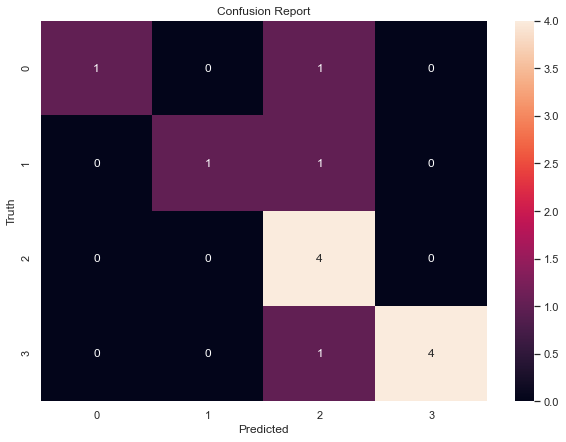

In [28]:
perform_classification_with_grid_search('Random Forest', X_train, X_test, y_train, y_test)

### Perform Classification using SVM Classifier

d:\pycharmprojects\data_mining_master_2020\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
d:\pycharmprojects\data_mining_master_2020\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pycharmprojects\data_mining_master_2020\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pycharmprojects\data_mining_master_2020\venv\lib\site-pack

Best Parameters:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best Accuracy Score Achieved in Grid Search:  0.5833333333333333
Classification Report
                     precision    recall  f1-score   support

ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ       0.00      0.00      0.00         2
  ΚΛΟΠΕΣ ΤΡΟΧΟΦΟΡΩΝ       0.00      0.00      0.00         2
           ΛΗΣΤΕΙΕΣ       0.44      1.00      0.62         4
    ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ       1.00      0.80      0.89         5

           accuracy                           0.62        13
          macro avg       0.36      0.45      0.38        13
       weighted avg       0.52      0.62      0.53        13

Accuracy per class
{0: 0.0, 1: 0.0, 2: 1.0, 3: 0.8}


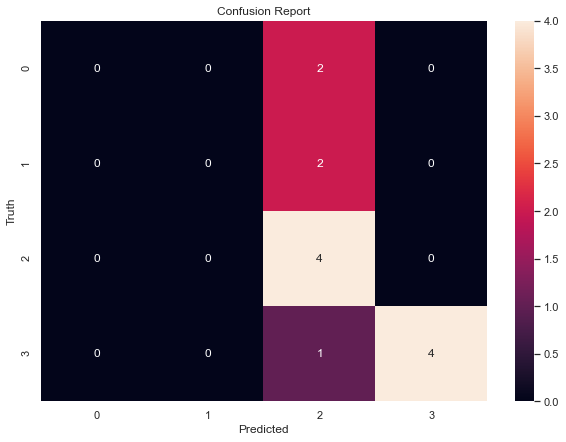

In [29]:
perform_classification_with_grid_search('SVM', X_train, X_test, y_train, y_test)

### Perform Classification using kNN Classifier

d:\pycharmprojects\data_mining_master_2020\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Parameters:  {'n_neighbors': 5}
Best Accuracy Score Achieved in Grid Search:  0.6333333333333333
Classification Report
                     precision    recall  f1-score   support

ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ       0.33      0.50      0.40         2
  ΚΛΟΠΕΣ ΤΡΟΧΟΦΟΡΩΝ       1.00      0.50      0.67         2
           ΛΗΣΤΕΙΕΣ       0.50      0.75      0.60         4
    ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ       1.00      0.60      0.75         5

           accuracy                           0.62        13
          macro avg       0.71      0.59      0.60        13
       weighted avg       0.74      0.62      0.64        13

Accuracy per class
{0: 0.5, 1: 0.5, 2: 0.75, 3: 0.6}


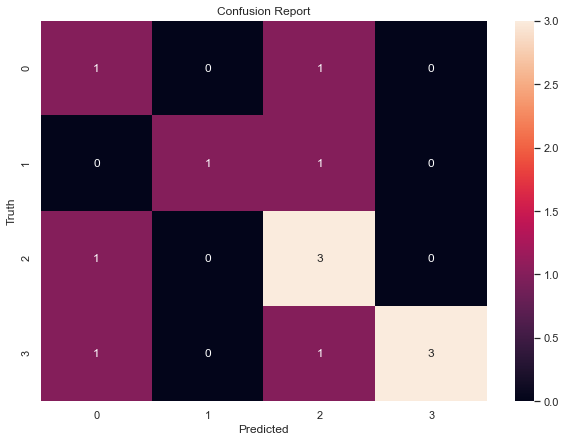

In [30]:
perform_classification_with_grid_search('kNN', X_train, X_test, y_train, y_test)

### Perform Classification using Decision Tree Classifier

d:\pycharmprojects\data_mining_master_2020\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Accuracy Score Achieved in Grid Search:  0.7
Classification Report
                     precision    recall  f1-score   support

ΚΛΟΠΕΣ - ΔΙΑΡΡΗΞΕΙΣ       0.50      0.50      0.50         2
  ΚΛΟΠΕΣ ΤΡΟΧΟΦΟΡΩΝ       1.00      0.50      0.67         2
           ΛΗΣΤΕΙΕΣ       0.43      0.75      0.55         4
    ΛΟΙΠΑ ΕΓΚΛΗΜΑΤΑ       1.00      0.60      0.75         5

           accuracy                           0.62        13
          macro avg       0.73      0.59      0.62        13
       weighted avg       0.75      0.62      0.64        13

Accuracy per class
{0: 0.5, 1: 0.5, 2: 0.75, 3: 0.6}


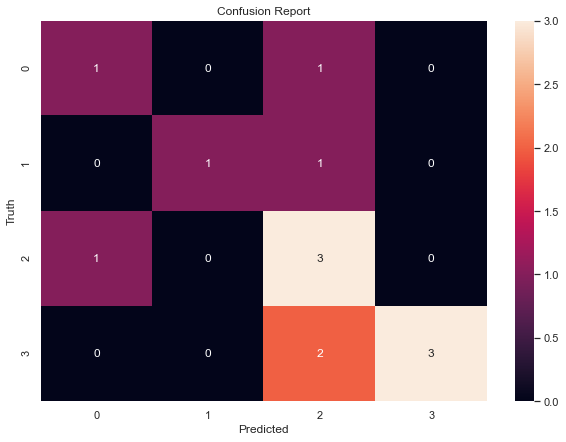

In [31]:
perform_classification_with_grid_search('Decision Tree', X_train, X_test, y_train, y_test)

From the above results and the confusion matrices, we can observe that the Random Forest performs better than the rest
algorithms.

However, the overall scores  are not too high. That makes sense, since the dataset is quite small and contains
cumulative information from the past crime years as well.